# 장고를 이용하여 게시판 앱 만들기

## 로그인과 로그아웃 구현하기

* 장고는 Django.contrib.auth앱을 제공, 로그인과 로그아웃을 구현할 수 있다.
* 로그인과 로그아웃은 공통기능이므로 common이라는 별도의 앱을 새로 만들어 준다.

In [ ]:
# mysite디렉토리 내에 생성해준다
django-admin starapp common

In [ ]:
# base.html과 동등한 위치에 navbar.html을 생성 하고 로그인, 로그아웃 정보 추가
# 화면 상단에 로그인 로그아웃 UI 출력
<nav class="navbar navbar-expand-lg navbar-light bg-light border-bottom">
    <a class="navbar-brand" href="{% url 'bbsnote:index' %}">BBSNote</a>
    <button class="navbar-toggler ml-auto" type="button" data-toggle="collapse" data-target="#navbarNav"
        aria-controls="navbarNav" aria-expanded="false" aria-label="Toggle navigation">
        <span class="navbar-toggler-icon"></span>
    </button>
    <div class="collapse navbar-collapse flex-grow-0" id="navbarNav">
        <ul class="navbar-nav">
            <li class="nav-item ">
                {% if user.is_authenticated  %}
                <a class="nav-link" href="{% url 'common:logout' %}">{{ user.username }} (로그아웃)</a>
                {% else %}
                <a class="nav-link" href="{% url 'common:login'  %}">로그인</a>
                {% endif %}
            </li>
        </ul>
    </div>
</nav>

In [ ]:
# base.html파일에 script들을 추가해준다
{% load static %}
<!DOCTYPE html>
<html lang="ko">
<head>
    <meta charset="UTF-8">
    <meta http-equiv="X-UA-Compatible" content="IE=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Document</title>
    <link rel="stylesheet" type="text/css" href="{% static 'css/bootstrap.min.css' %}">
    <script src="https://cdn.jsdelivr.net/npm/jquery@3.5.1/dist/jquery.slim.min.js" integrity="sha384-DfXdz2htPH0lsSSs5nCTpuj/zy4C+OGpamoFVy38MVBnE+IbbVYUew+OrCXaRkfj" crossorigin="anonymous"></script>
    <script src="https://cdn.jsdelivr.net/npm/popper.js@1.16.1/dist/umd/popper.min.js" integrity="sha384-9/reFTGAW83EW2RDu2S0VKaIzap3H66lZH81PoYlFhbGU+6BZp6G7niu735Sk7lN" crossorigin="anonymous"></script>
    <script src="https://cdn.jsdelivr.net/npm/bootstrap@4.6.2/dist/js/bootstrap.min.js" integrity="sha384-+sLIOodYLS7CIrQpBjl+C7nPvqq+FbNUBDunl/OZv93DB7Ln/533i8e/mZXLi/P+" crossorigin="anonymous"></script>
</head>
<body>
    {% include "navbar.html" %}

    <!-- 기본 템플릿 안에 삽입될 내용 Start -->
    {% block content %}
    {% endblock %}
    <!-- 기본 템플릿 안에 삽입될 내용 End -->
    {% block script %}
    {% endblock %}
</body>
</html>

In [ ]:
# config/settings.py파일에 추가
INSTALLED_APPS = [
    "django.contrib.admin",
    "django.contrib.auth",
    "django.contrib.contenttypes",
    "django.contrib.sessions",
    "django.contrib.messages",
    "django.contrib.staticfiles",
    "bbsnote.apps.BbsnoteConfig",
    "common.apps.CommonConfig",
]


# settings.py파일 하단에 다음을 추가
LOGIN_REDIRECT_URL = '/'
LOGOUT_REDIRECT_URL = '/'

* common URL 사용을 위해 추가하고, 앞에 설정한 '/'에 대응하기 위한 URL path도 추가한다.

In [ ]:
# config/urls.py에 url주소 추가
from django.contrib import admin
from django.urls import path, include
from bbsnote import views

urlpatterns = [
    path("admin/", admin.site.urls),
    path("bbsnote/", include('bbsnote.urls')),
    # 'common/' 문자열과 일치하게 되면 'common.urls'모듈에 정의된 URL패턴 목록이 포함됨
    path("common/", include('common.urls')),
    path('', views.index, name='index'),
]


* Django.contrib.auth 앱 LoginView클래스를 사용할 것이므로, urls.py를 수정해준다.

In [ ]:
# common/urls.py파일 수정
from django.contrib.auth import views as auth_views
from django.urls import path

# 앱의 이름을 'common'으로 정의
app_name = 'common'

urlpatterns = [
    # 'login/'의 경로로 들어온다면, 장고가 제공하는 auth_views.LoginView를 사용하여 뷰 함수를 실행
    # 템플릿 이름은 'common.login.html'에서 가져오며, 이름은 로그인으로 지정한다.
    path('login/', auth_views.LoginView.as_view(template_name='common/login.html'), name='login')
    # 'logout/'의 경로로 들어온다면, 장고가 제공하는 auth_views.LogoutView를 사용하여 뷰 함수를 실행
    # 이름은 로그아웃으로 지정한다
    path('logout/', auth_views.LogoutView.as_view(), name='logout')
]

* 아이디와 비밀번호를 입력받는 페이지와 로그인에 실패했을 경우 오류 메시지를 표현할 부분을 추가하여 준다.

In [ ]:
{% extends "base.html" %}
{% block content  %}
<div class="container my-3">
    <div class="row">
        <div class="col-4">
            <h4>로그인</h4>
        </div>
        <div class="col-8 text-right">
            <span>또는 <a href="">계정을 만드세요.</a></span>
        </div>
    </div>
    <form method="post" class="post-form" action="{% url 'common:login' %}">
        {% csrf_token %}
        <input type="hidden" name="next" value="{{ next }}">  <!-- 로그인 성공후 이동되는 URL -->
        {% include "form_errors.html"  %}
        <div class="form-group">
            <label for="username">사용자ID</label>
            <input type="text" class="form-control" name="username" id="username"
                value="{{form.username.value|default_if_none:''}}">
        </div>
        <div class="form-group">
            <label for="password">비밀번호</label>
            <input type="password" class="form-control" name="password" id="password"
                value="{{form.password.value|default_if_none:''}}">
        </div>
        <button type="submit" class="btn btn-primary">로그인</button>
    </form>
</div>
{% endblock  %}

In [ ]:
{% if form.errors %}
    {% for field in form %}
        {% for error in field.errors %}  <!-- 필드 오류를 출력한다. -->
            <div class="alert alert-danger">
                <strong>{{ field.label }}</strong>
                {{ error }}
            </div>
        {% endfor %}
    {% endfor %}
    {% for error in form.non_field_errors %}   <!-- 넌필드 오류를 출력한다. -->
        <div class="alert alert-danger">
            <strong>{{ error }}</strong>
        </div>
    {% endfor %}
{% endif %}

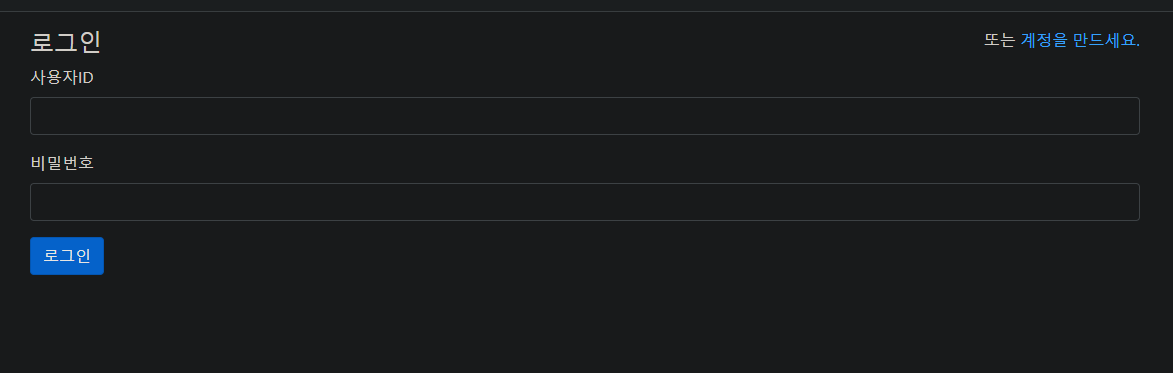

## 회원가입 기능 추가하기

* 장고에선 회원가입 또한 제공해준다.
* Django.contrib.auth 앱을 이용하여 구현한다.

In [ ]:
# common/forms.py파일 생성
from django import forms
from django.contrib.auth.forms import UserCreationForm
from django.contrib.auth.models import User

# UserForm클래스 선언
class UserForm(UserCreationForm):
    # 이메일 필드를 추가하고 라벨의 이름을 이메일로 선언, email객체에 저장
    email = forms.EmailField(label="이메일")
    class Meta:
        model = User
        fields = ('username', 'email')

* UserCreationForm은 username, password1, password2(비밀번호 확인)를 기본적으로 가진다.
* email 속성 추가를 위해 UserCreationForm을 상속받는 UserForm을 생성한다.

In [ ]:
# common/views.py파일에 추가
from django.shortcuts import render, redirect
from django.contrib.auth import authenticate, login

from .forms import UserForm

def signup(requsest):
    # 요청방법이 POST방식이라면
    if request.method == "POST":
        form = UserForm(request.POST)
        if form.is_valid():
            # form안의 내용 저장
            form.save()
            # form태그의 username을 가져온다
            username = form.cleaned_data.get('username')
            # form태그의 password1을 가져온다
            raw_password = form.cleaned_data.get('password1')
            user = authenticate(username=username, password=raw_password)
            # 요청정보와 함께 user정보를 넘김, 자동 로그인 처리과정
            login(request, user)
            # index로 가라(리다이렉트)
            # 'bbsnote:index'로 입력하게 되면 웹 서버의 주소가 '127.0.0.1:8000/bbsnote/'로 표시된다
            return redirect('index')
        
    # POST방식이 아니라면(GET방식) form에 내용없이 출력
    else:
        form = UserForm()
    # 'common.signup.html' 템플릿을 사용하여 응답을 생성하고, 템플릿에 'form'변수로 폼 객체를 랜더링하여 전달
    return render(request, 'common/signup.html', {'form':form})

In [ ]:
# templates/common/signup.html
{% extends "base.html" %}
{% block content %}
<div class="container my-3">
    <div class="row my-3">
        <div class="col-4">
            <h4>계정생성</h4>
        </div>
        <div class="col-8 text-right">
            <span>또는 <a href="{% url 'common:login' %}">로그인 하세요.</a></span>
        </div>
    </div>
    <form method="post" class="post-form">
        {% csrf_token %}
        {% include "form_errors.html" %}
        <div class="form-group">
            <label for="username">사용자 이름</label>
            <input type="text" class="form-control" name="username" id="username"
                value="{{ form.username.value|default_if_none:''  }}">
        </div>
        <div class="form-group">
            <label for="password1">비밀번호</label>
            <input type="password" class="form-control" name="password1" id="password1"
                value="{{ form.password1.value|default_if_none:'' }}">
        </div>
        <div class="form-group">
            <label for="password2">비밀번호 확인</label>
            <input type="password" class="form-control" name="password2" id="password2"
                value="{{ form.password2.value|default_if_none:''  }}">
        </div>
        <div class="form-group">
            <label for="email">이메일</label>
            <input type="text" class="form-control" name="email" id="email"
                value="{{ form.email.value|default_if_none:'' }}">
        </div>
        <button type="submit" class="btn btn-primary">생성하기</button>
    </form>
</div>
{% endblock %}

In [ ]:
# templates/common/login.html에 추가
{% extends "base.html" %}
{% block content  %}
<div class="container my-3">
    <div class="row">
        <div class="col-4">
            <h4>로그인</h4>
        </div>
        <div class="col-8 text-right">
            <span>또는 <a href="{% url 'common:signup' %}">계정을 만드세요.</a></span>
        </div>
    </div>
    <form method="post" class="post-form" action="{% url 'common:login' %}">
        {% csrf_token %}
        <input type="hidden" name="next" value="{{ next }}">  <!-- 로그인 성공후 이동되는 URL -->
        {% include "form_errors.html"  %}
        <div class="form-group">
            <label for="username">사용자ID</label>
            <input type="text" class="form-control" name="username" id="username"
                value="{{form.username.value|default_if_none:''}}">
        </div>
        <div class="form-group">
            <label for="password">비밀번호</label>
            <input type="password" class="form-control" name="password" id="password"
                value="{{form.password.value|default_if_none:''}}">
        </div>
        <button type="submit" class="btn btn-primary">로그인</button>
    </form>
</div>
{% endblock  %}

In [ ]:
# common/urls.py파일에 signup의 URL패턴 추가
urlpatterns = [
    # 'login/'의 경로로 들어온다면, 장고가 제공하는 auth_views.LoginView를 사용하여 뷰 함수를 실행
    # 탬플릿 이름은 'common/login.html'에서 가져오며, 이름은 로그인으로 지정한다
    path('login/', auth_views.LoginView.as_view(template_name='common/login.html'), name='login'),
    # 'logout/'의 경로로 들어온다면, 장고가 제공하는 auth_views.LogoutView를 사용하여 뷰 함수를 실행
    # 이름은 로그아웃으로 지정한다 
    path('logout/', auth_views.LogoutView.as_view(), name='logout'),
    path('signup/', views.signup, name='signup'),
]

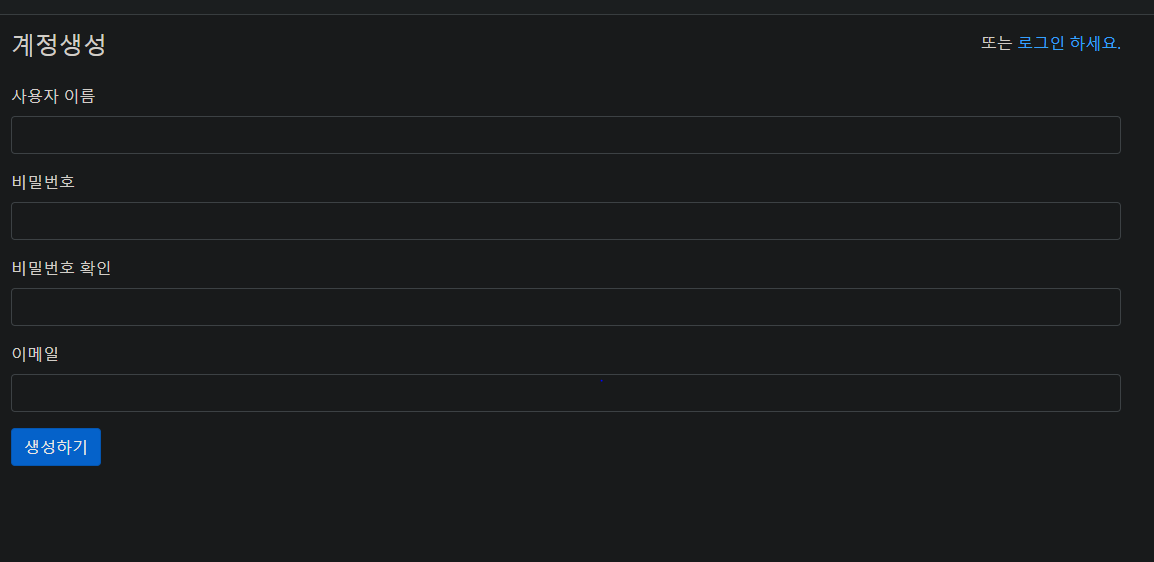

## 게시판 페이징 적용하기

In [ ]:
# bbsnote/views.py의 index함수 수정
from django.core.paginator import Paginator

def index(request):
    # 입력 인자 추가
    # get방식으로 요청하여 페이지를 가져오되, 페이지에 값이 없으면 1로 초기화
    page = request.GET.get('page', 1)
    # 조회
    board_list = Board.objects.order_by('-create_date')
    # 페이징 함수를 통해 페이지 리스트를 n개씩 볼 수 있도록 나누어 페이징을 한다.
    paginator = Paginator(board_list, 5)
    # 현재 페이지를 나타내준다
    page_obj = paginator.get_page(page)
    context = {'board_list': page_obj}
    return render(request, 'bbsnote/board_list.html', context)

* 사이트에서 bbsnote/?page=2로 확인하면 페이징이 된 것을 볼 수 있다. 이때 ?뒤에 나오는 모두 파라미터라고 보면 된다.

* 장고의 Paginator 클래스를 이용하면 다음 속성들 사용이 가능하여 페이징 처리가 간단해 진다.
* 페이징 처리시 사용되는 속성들

|항목|설명|
|----|----|
|paginator.count|전체 게시물 수 |
|paginator.per_page|페이지당 보여줄 게시물 개수|
|paginator.page_range|페이지 범위|
|number|페이지 범위|
|previous.page_number|이전 페이지 번호|
|next.page_number|다음 페이지 번호|
|has_previous|이전 페이지 유무|
|has_next|다음 페이지 유무|
|start_index|현재 페이지 시작 인덱스(1부터 시작)|
|end_index|현재 페이지의 끝(1부터 시작)|

## 템플릿 필터 적용하기

* 템플릿 필터: 템플릿 태그에서 '|'문자 뒤에 사용하는 필터
* 게시글 앞에 번호를 붙이고 페이징 결과를 확인

In [ ]:
# templates/bbsnote/board_list.html파일 수정
{% extends 'base.html' %}
{% block content %}
<div class="container my-3">
    <table class="table">
        <thead>
        <tr class="text-center thead-dark"> 
            <th></th>           
            <th style="width:50%">제목</th>
            <th>작성일시</th>
        </tr>
        </thead>
        <tbody>
        {% if board_list %}
            {% for board in board_list %}
            <tr class="text-center">
                <td>{{forloop.counter}}</td>
                <td class="text-left">
                    <a href="{% url 'bbsnote:detail' board.id %}">{{ board.subject }}</a>                
                </td>            
                <td>{{ board.create_date }}</td>
            </tr>
            {% endfor %}
            {% else %}
            <tr>
                <td colspan="3">글이 없습니다.</td>
            </tr>
            {% endif %}
            </tbody>
        </table> 
        <!-- 해당경로로 데이터를 get방식으로 넘겨받는다 -->
        <a href="{% url 'bbsnote:board_create' %}" class="btn btn-primary">등록</a>
</div>
{% endblock %}

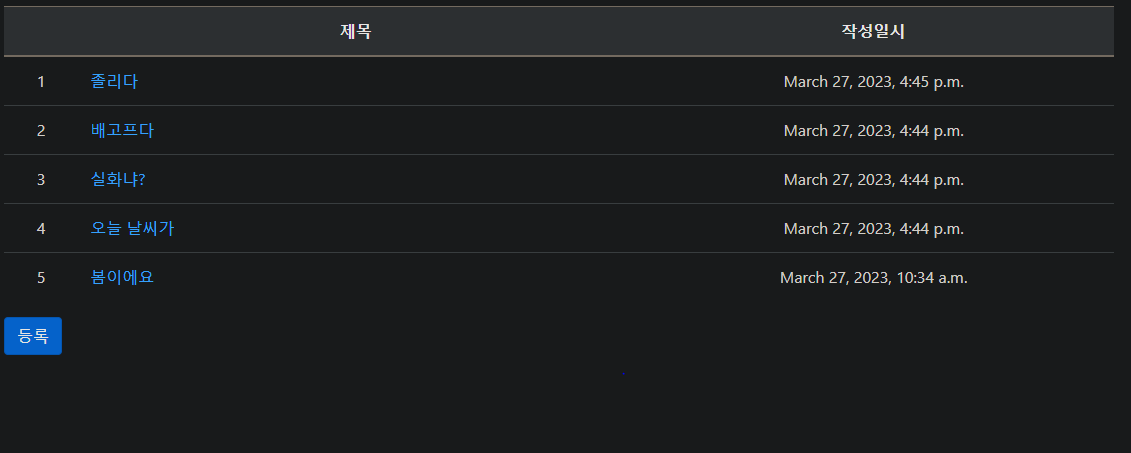

* 게시물 번호 공식: 일련번호 = 전체 게시물 개수 - 시작인덱스 - 현재 인덱스 + 1
* 더하기 필터에는 변수를 적용할 수 없기에 뻬기 필터를 만든다.

* 게시물 전체 건수가 12개라면, 첫번째 페이지는 12-3의 역순으로 보여주고, 두번째 페이지는 2~1이 보여진다. 

* 시작 인덱스는 페이지당 시작되는 게시물의 시작 번호를 의미, 예를 들어 페이지당 게시물을 10건씩 보여준다면 1페이지의 시작 인덱스는 1, 2페이지의 시작 인덱스는 11이 된다. 현재 인덱스는 페이지에 보여지는 게시물 개수만큼 0부터 1씩 증가되는 번호이다.

* 따라서 전체 게시물 개수가 12개이고 페이지당 10건씩 게시물을 보여준다면 공식에 의해 1페이지의 번호는 12 - 1 - (0-9반복) + 1 이 되어 12-3까지 표시되고 2페이지의 경우 12 - 11 - (0-9반복) + 1이 되어 2또는 1이 표시될 것이다.

In [ ]:
# bbsnote폴더 안에 templatetag폴더를 새로 생성하고 bbsnote_filter.py파일을 생성
from django import template

register = template.Library()
# 애너테이션을 적용하면 템플릿에서 함수를 필터로 사용할 수 있게 된다
# 장고에는 빼기 필터가 존재하지 않아 'add:-5'와 같이 숫자를 직접입력해야 한다.
# 단, add필터에는 변수적용을 할 수 없으므로 직접 빼기 함수를 만들어 준다.
@ register.filter
def sub(value, arg):
    return value - arg

|공식요소|설명|
|----|----|
|question_list.paginator.count|전체 게시물 수|
|question_list.start_index|시작 인덱스(1부터 시작)|
|forloop.counter0|forloop내의 현재 인덱스, forloop.counter0은 0부터, forloop.counter는 1부터 시작|

In [ ]:
<!-- base.html의 양식을 상속받음 -->
{% extends 'base.html' %}
{% load bbsnote_filter %}
{% block content %}
<div class="container my-3">
    <table class="table">
        <thead>
        <tr class="text-center thead-dark"> 
            <th></th>           
            <th style="width:50%">제목</th>
            <th>작성일시</th>
        </tr>
        </thead>
        <tbody>
        {% if board_list %}
            {% for board in board_list %}
            <tr class="text-center">
                <td>{{board_list.paginator.count | sub:board_list.start_index | sub:forloop.counter0 | add:1 }}</td>
                <td class="text-left">
                    <a href="{% url 'bbsnote:detail' board.id %}">{{ board.subject }}</a>                
                </td>            
                <td>{{ board.create_date }}</td>
            </tr>
            {% endfor %}
            {% else %}
            <tr>
                <td colspan="3">글이 없습니다.</td>
            </tr>
            {% endif %}
            </tbody>
        </table> 
        <!-- 해당경로로 데이터를 get방식으로 넘겨받는다 -->
        <a href="{% url 'bbsnote:board_create' %}" class="btn btn-primary">등록</a>
</div>
{% endblock %}

* 필터를 사용하여 게시물 번호 공식을 대입하면 아래와 같이 잘 정렬된것을 알 수 있다.

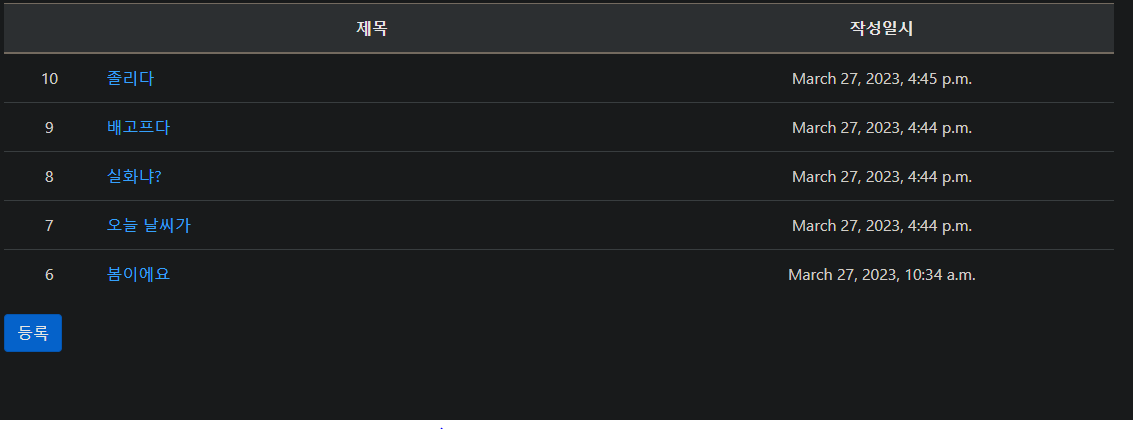

In [ ]:
<!-- base.html의 양식을 상속받음 -->
{% extends 'base.html' %}
{% load bbsnote_filter %}
{% block content %}
<div class="container my-3">
    <table class="table">
        <thead>
        <tr class="text-center thead-dark"> 
            <th></th>           
            <th style="width:50%">제목</th>
            <th>작성일시</th>
        </tr>
        </thead>
        <tbody>
        {% if board_list %}
        {% for board in board_list %}
        <tr class="text-center">
            <td>{{ board_list.paginator.count|sub:board_list.start_index|sub:forloop.counter0|add:1 }}</td>
            <td class="text-left">
                <a href="{% url 'bbsnote:detail' board.id %}">{{ board.subject }}</a>                
            </td>            
            <td>{{ board.create_date }}</td>
        </tr>
        {% endfor %}
        {% else %}
        <tr>
            <td colspan="3">질문이 없습니다.</td>
        </tr>
        {% endif %}
        </tbody>
    </table> 
    <!-- 페이징처리 시작 -->
    <ul class="pagination justify-content-center">
        <!-- 이전페이지 -->
        {% if board_list.has_previous %}
        <li class="page-item">
            <a class="page-link" data-page="{{ board_list.previous_page_number }}" href="#">이전</a>
        </li>
        {% else %}
        <li class="page-item disabled">
            <a class="page-link" tabindex="-1" aria-disabled="true" href="#">이전</a>
        </li>
        {% endif %}
        <!-- 페이지리스트 -->
        {% for page_number in board_list.paginator.page_range %}
        {% if page_number >= board_list.number|add:-5 and page_number <= board_list.number|add:5 %}
            {% if page_number == board_list.number %}
            <li class="page-item active" aria-current="page">
                <a class="page-link" data-page="{{ page_number }}" href="#">{{ page_number }}</a>
            </li>
            {% else %}
            <li class="page-item">
                <a class="page-link" data-page="{{ page_number }}" href="#">{{ page_number }}</a>
            </li>
            {% endif %}
        {% endif %}
        {% endfor %}
        <!-- 다음페이지 -->
        {% if board_list.has_next %}
        <li class="page-item">
            <a class="page-link" data-page="{{ board_list.next_page_number }}" href="#">다음</a>
        </li>
        {% else %}
        <li class="page-item disabled">
            <a class="page-link" tabindex="-1" aria-disabled="true" href="#">다음</a>
        </li>
        {% endif %}
    </ul>
    <!-- 페이징처리 끝 -->
    <a href="{% url 'bbsnote:board_create' %}" class="btn btn-primary">등록</a>   
</div>
<form id="searchForm" method="get" action="{% url 'index' %}">    
    <input type="hidden" id="page" name="page" value="{{ page }}">    
</form>
{% endblock %}
{% block script %}
<script type='text/javascript'>
$(document).ready(function(){
    $(".page-link").on('click', function() {
        $("#page").val($(this).data("page"));
        $("#searchForm").submit();
    });     
});
</script>
{% endblock %}


* 템플릿을 개선하여 가운데 이전과 다음 버튼을 생성했다.

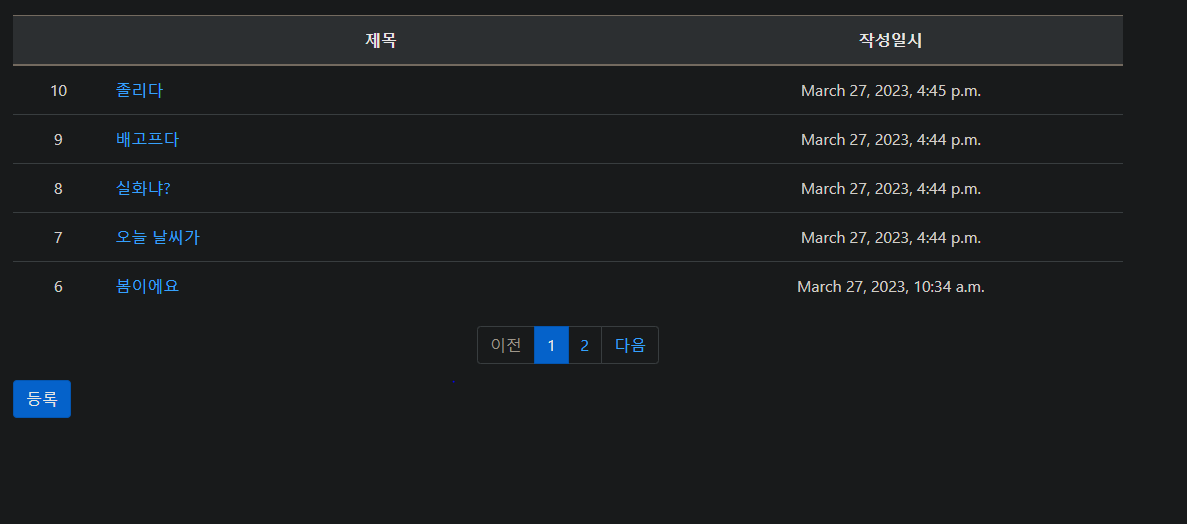